# Drug-Drug Similarity Using Text Mining Techniques


                                                                                by Alberto Olivares Alarcos

This notebook gives a flavour of how to obtain a measurement of similarity between pairs of drugs by means of text mining techniques. The measurement is computed as a pairwise tf-idf similarity matrix based on a combination of several textual fields from the database, DrugBank$^{[1]}$. The similarity matrix is used to cluster the drugs into 14 groups. An evaluation of those obtained clusters is done at the end of the experiment. 

Note that any time we talk about similarity, we are also talking about distance, since we can obtain one from the another one just substracting one of them to the unit (e.g. the similarity is one minus the distance, and vice-versa).

[1] *The DrugBank database is a comprehensive, freely accessible, online database containing information on drugs and drug targets. For more information visit: https://www.drugbank.ca/.*


## Experimental Setup

As said above, in this work we are going to compute a measure of similarity among drugs extracted from the Drugbank database. Our aim is to show how this measure could be useful, so that we use it to cluster the drugs. In this section, we explain the main parts of our experiment and the decision making done when choosing the tools used within this work. 

### Why Natural Language?

The medical domain is one of the most well documented domains, not only academically, most of the medical revisions and diagnostics are written down into a report. Thus, in this domain, there is a lot of useful information for creating intelligent systems which is in a natural language format. 

In this project, we are interested in computing similarity meassurement among drugs and we think that we could use text mining techniques to do so. Specifically, we are using different textual fields from the Drugbank database: *description, indication and pharmacodynamics*. The experiment is restricted then to the number of drugs which actually contain information in those fields (1661 drugs).

### Drugs representation

For the clustering of the Drugbank database, it is necessary first and foremost to have a measure of similarity (or dissimilarity) among the drugs. To this purpose, it is required to find a suitable representation of the drugs that allows us to compute their similarities. In this case, the drugs were represented in a vector space model, which is an algebraic model for representing text documents and, thus, similarities can be computed in this space. To obtain the vector space model representation of the drugs, the data fields: *description,
indication and pharmacodynamics* –all expressed in natural language– were concatenated and, after removing stop words and transforming to lowercase, their term frequency-inverse document frequency (tf-idf ) representation was computed. In this case, each document used to compute the tf-idf is the concatenation of the fields of each drug, while the corpus is formed by all those documents as a whole.  

Thus, the the data is represented as the matrix $M  \epsilon  \mathbb{R}^{nxp}$, where *n* is the number of drugs and *p* the number of words in the whole corpus. 

### Sparseness as a problem

Usually, the number of terms within a courpus is large, this together with the fact that only few terms appear in a specific document give room to a sparse matrix. The high dimensionality and sparseness of the matrix *M* entail to a well-known phenomenon called *'curse of dimensionality'*. In a nutshell, we lose statistical significance and the *Euclidean* distance becomes meaningless.

### Dimension reduction as a solution

Reducing the dimension of the vector space model we have computed is the solution proposed in this work. Specifically, we use the technique that in Information Retrieval is known as *Latent Semantic Indexing* (*LSI*), for us, *Latent Semantic Analysis* (*LSA*). 

Basically, *LSA* uses *Singular Value Decomposition* (*SVD*) to find patterns in the relationships between terms and concepts found within a corpus. As a result, we obtain a representation of our data in a reduced dimensional space in return for losing part of the information. 

### Clustering algorithm selection

There are a lot of clustering algorithms to choose from. In our case, we are working with Python, so that we could restrict the selection to those available among all Python libraries. The standard sklearn clustering suite has thirteen different clustering classes. 

The main aspect for us to take into account when choosing the proper algorithm is not different from any other problem in data science and machine learning: Data. Depending on the data we have and the format in which we have it, it will be more suitable to use one algorithm or another. In this work, the data is textual and is represented into two different ways: matrix of samples (drugs) and features (tf-idf) and similarity/distance matrix. We could use any of the algorithms from *sklearn* library, however, this experiment is part of a bigger project in which we will compute similarity using other approaches. In those approaches we do have a simiarity matrix, but not a matrix with samples and features. From the documentation of *sklearn* we have extracted the next paragrahp about the input data of the clustering algorithms:

One important thing to note is that the algorithms implemented in this module can take different kinds of matrix as input. All the methods accept standard data matrices of shape [n_samples, n_features]. These can be obtained from the classes in the sklearn.feature_extraction module. For AffinityPropagation, SpectralClustering and DBSCAN one can also input similarity matrices of shape [n_samples, n_samples]. These can be obtained from the functions in the sklearn.metrics.pairwise module.

Thus, just three options fit our experiment requirements: Affinity Propagation, Spectral Clustering and DBSCAN. We have chosen the Spectral Clustering algorihtm which is a good option for graph clustering, fact that we think fits our problem, since we are using a database which follows a graph structure (like a taxonomy). The only problem with this algorithm is the need of choosing the number of clusters. Nevertheless, that is something we could deal with since the data is structured in groups of drugs defined by several data fields. 

### Choosing the number of clusters

As said before, Drugbank database is structured forming different groups of drugs based on different characteristics: 

- Groups: Illicit, aproved, withdrawn, etc.
- Kingdoms: Organic and Inorganic.
- State: Solid, Liquid and Gas.
- ATC code: The Anatomical Therapeutic Chemical (ATC) Classification System is used for the classification of active ingredients of drugs according to the organ or system on which they act and their therapeutic, pharmacological and chemical properties.

In this work we use the ATC code.The system has a total of 5 levels, and the code consists of 7 alphanumerical characters, which can be read in the following way:

- First level: character 0 - for example ’A’
- Second level: characters 1-2, numbers - 02
- Third level: character 3 - for example ’C’
- Fourth level: character 4 - for example ’A’
- Fifth level: character 5-6 - for example 04

Although each level has it’s significance, we have decided to focus on the first one of
the system, which determines the anatomical main group and consists of 14 categories, as shown in the following Table:


|Code | Contents|
|-----|---------|
|A    | Alimentary tract and metabolism |
|B    | Blood and blood forming organs |
|C    | Cardiovascular system |
|D    | Dermatologicals |
|G    | Genito-urinary system and sex hormones | 
|H    | Systemic hormonal preparations, excluding sex hormones and insulins |
|J    | Antiinfectives for systemic use |
|L    | Antineoplastic and immunomodulating agents |
|M    | Musculo-skeletal system |
|N    | Nervous system |
|P    | Antiparasitic products, insecticides and repellents |
|R    | Respiratory system |
|S    | Sensory organs |
|V    | Various |



Therefore, the number of clusters we are going to use is fourteen, then, we will evaluate if actually this is a good decision.

## IMPLEMENTATION

In [1]:
# Headers 
from sklearn.preprocessing import Normalizer, normalize, scale 
from sklearn.pipeline import make_pipeline 
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering 
import matplotlib.pyplot as plt
from operator import itemgetter
from IPython.display import Image
import numpy
import os
import sys
import csv

HERE = os.path.abspath(os.path.dirname("__file__"))
sys.path.append(os.path.join(HERE, ".."))

from utils.drugbank_accessor_ET import *
from utils.general_utils import *
from utils.evaluation_utils import *

print("Done")

Done


In [2]:
# Global varialbles
n_comp_list = [100, 200, 500] # Dimensions used to reduce the dimension of our vector space.

## DISTANCE/SIMILARITY MATRIX COMPUTATION

In [3]:
# Reading the corpus and creating a dictionary of drugs. 
zip_filepath = './../corpus/drugbank.xml_release_2017_12_20.zip' # Version 5.0.11
filename = 'drugbank.xml'

file = read_zip_file(zip_filepath, filename)
drugs = map_drugbank_from_file(file)
print(len(drugs))

1661


In [4]:
# Processing data and checking all instances have the fields we are interested in. 
ids = sorted(drugs.keys())
ids_dic = dict(enumerate(ids))
total_cases = len(ids)
print("Total cases ", total_cases)

attribute = ['description', 'indication', 'pharmacodynamics']

variable =  drug_term_dictionary(drugs, ids_dic, attr=attribute) # list of all the concatenated att for each drug

Total cases  1661
0  drugs found with empty fields


Total ATC:  3007


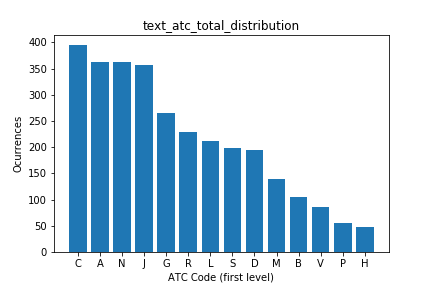

In [5]:
# Distribution of ATC Codes first level of the total set of used drugs
    
atc_first_level_all_drugs = list()
for db_id in ids:
    atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
    for atc_code in atc_codes_dbid:
        atc_first_level_all_drugs.append(atc_code[0])

print('Total ATC: ', len(atc_first_level_all_drugs))

path_images = './../plots/evaluation/clustering/text_mining/'

if not (os.path.exists('./../plots/evaluation/clustering/text_mining/text_atc_total_distribution.png')):
    save_histogram(atc_first_level_all_drugs, path_images, \
                       'text_atc_total_distribution')
else: 
    img = Image(filename = path_images + 'text_atc_total_distribution.png', width=500, height=500)
    display(img)
    

In [19]:
print(atc_first_level_all_drugs)

['B', 'L', 'R', 'L', 'L', 'B', 'L', 'L', 'L', 'S', 'B', 'V', 'H', 'L', 'B', 'B', 'L', 'B', 'B', 'H', 'L', 'L', 'V', 'L', 'L', 'L', 'H', 'V', 'B', 'L', 'R', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'G', 'L', 'H', 'B', 'L', 'V', 'H', 'L', 'M', 'R', 'G', 'A', 'A', 'A', 'A', 'M', 'D', 'D', 'V', 'M', 'H', 'L', 'H', 'A', 'B', 'B', 'L', 'V', 'B', 'L', 'L', 'V', 'B', 'L', 'G', 'G', 'L', 'L', 'B', 'A', 'A', 'A', 'A', 'L', 'L', 'L', 'L', 'V', 'V', 'J', 'V', 'H', 'M', 'A', 'B', 'B', 'L', 'A', 'V', 'A', 'S', 'L', 'L', 'G', 'L', 'G', 'L', 'L', 'B', 'A', 'D', 'A', 'A', 'H', 'L', 'L', 'H', 'G', 'L', 'J', 'L', 'L', 'V', 'A', 'B', 'B', 'B', 'A', 'A', 'N', 'B', 'B', 'A', 'A', 'S', 'G', 'A', 'V', 'A', 'D', 'A', 'A', 'B', 'A', 'N', 'A', 'A', 'B', 'B', 'B', 'B', 'R', 'D', 'A', 'V', 'S', 'A', 'A', 'M', 'M', 'A', 'M', 'M', 'M', 'M', 'B', 'C', 'C', 'C', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'L', 'R', 'R', 'M', 'V', 'N', 'N', 'N', 'N', 'L', 'N', 'A', 'N', 'N', 'J', 'S', 'C', 'S',

In [5]:
# Sparse matrix from the data by performing 'term frequency–inverse document frequency' (tf-idf) 
tfidf_variable = TfidfVectorizer(tokenizer=tokenize, stop_words='english',
                                 ngram_range=(1,1))
tfs_variable = tfidf_variable.fit_transform(variable)

In [6]:
# Dimensionality reduction (too much sparseness in our data matrix) 
print("tf-idf matrix dim: ", tfs_variable.A.shape)
tfs_scale = scale(tfs_variable.A, axis=0, with_std=False)
print("Num vars: ", len(np.mean(tfs_scale, axis=0)))
print('Total variance: ', np.var(tfs_variable.A,axis=0).sum())



tfs_red = []
for n_comp in n_comp_list: 
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    tfs_red.append(lsa.fit_transform(tfs_scale))

tf-idf matrix dim:  (1661, 14434)
Num vars:  14434
Total variance:  0.9772388585304425


In [7]:
# Distance matrix and saving data (if they do not already exist)
if not(os.path.exists('./../data/text_mining/dist_matrix.npy')):
    dist = squareform(pdist(tfs_scale, 'euclidean'))
    numpy.save('./../data/text_mining/dist_matrix.npy',dist)

for i in range (0, len(n_comp_list)):
    if not(os.path.exists('./../data/text_mining/dist_matrix_reduced'+str(n_comp_list[i])+'c.npy')):
        dist_red = squareform(pdist(tfs_red[i], 'euclidean'))
        numpy.save('./../data/text_mining/dist_matrix_reduced'+str(n_comp_list[i])+'c.npy',dist_red)

## CLUSTERING

In [6]:
# Variables definition
ids = sorted(drugs.keys())
ids_dic = dict(enumerate(ids))

ncomp = '100'
dist = numpy.load('./../data/text_mining/dist_matrix.npy')
dist_red = numpy.load('./../data/text_mining/dist_matrix_reduced'+ncomp+'c.npy')

In [7]:
# We need to normalize the distance matrix and then compute the similarity matrix (needed for the SpectralClustering)
norm_matrix = normalize_matrix(dist)
sim_matrix = bidirectional_conversion_between_distance_and_similarity_matrix(norm_matrix)

norm_matrix_red = normalize_matrix(dist_red)
sim_matrix_red = bidirectional_conversion_between_distance_and_similarity_matrix(norm_matrix_red)

In [8]:
# Spectral Clustering
sca = SpectralClustering(affinity="precomputed", n_clusters=14)
sca.fit(sim_matrix_red)
nclust = max(sca.labels_)+1

/usr/lib/python3/dist-packages/scipy/sparse/csgraph/_laplacian.py:71: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


In [9]:
# Print the clusters
clusters_idx = label_idx(sca.labels_, nclust)

clusters_dbid = dict()
for l in clusters_idx.keys():
     clusters_dbid[l] = idx_to_id(clusters_idx[l], ids_dic)
print('Number of clusters: ', max(sca.labels_)+1)
print('Clusters:\n ', clusters_dbid)

Number of clusters:  14
Clusters:
  {0: ['DB00017', 'DB00177', 'DB00178', 'DB00191', 'DB00195', 'DB00203', 'DB00206', 'DB00211', 'DB00212', 'DB00214', 'DB00216', 'DB00217', 'DB00232', 'DB00235', 'DB00264', 'DB00270', 'DB00275', 'DB00280', 'DB00287', 'DB00310', 'DB00325', 'DB00326', 'DB00335', 'DB00343', 'DB00346', 'DB00350', 'DB00368', 'DB00373', 'DB00374', 'DB00381', 'DB00384', 'DB00388', 'DB00390', 'DB00393', 'DB00401', 'DB00411', 'DB00421', 'DB00435', 'DB00436', 'DB00457', 'DB00484', 'DB00489', 'DB00492', 'DB00511', 'DB00519', 'DB00521', 'DB00524', 'DB00528', 'DB00542', 'DB00559', 'DB00561', 'DB00562', 'DB00571', 'DB00572', 'DB00575', 'DB00584', 'DB00590', 'DB00594', 'DB00598', 'DB00606', 'DB00610', 'DB00612', 'DB00622', 'DB00640', 'DB00654', 'DB00657', 'DB00661', 'DB00668', 'DB00678', 'DB00680', 'DB00687', 'DB00691', 'DB00692', 'DB00695', 'DB00696', 'DB00699', 'DB00703', 'DB00722', 'DB00723', 'DB00727', 'DB00742', 'DB00758', 'DB00761', 'DB00765', 'DB00770', 'DB00774', 'DB00775', 'D

Max distance:  1.6418816586751022


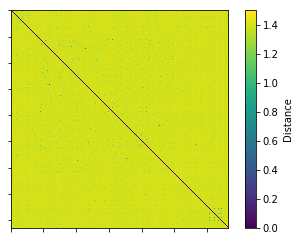

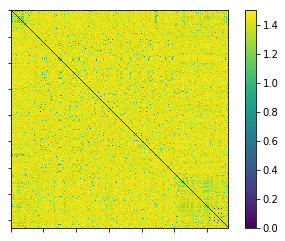

In [8]:
# Visual evaluation
maxdist = 0
if dist.max() >= dist_red.max():
    maxdist = dist.max()
else:
    maxdist = dist_red.max()
print('Max distance: ', maxdist)

maxdist = 1.5

fig = plt.figure()
plt.tick_params(
    axis='both',
    labelleft='off',
    labelbottom='off')
plt.imshow(dist, interpolation='nearest', vmin=0, vmax=maxdist)
plt.colorbar().set_label('Distance')
plt.show()
plt.savefig('./../plots/text_mining/dist_matrix.png')

fig = plt.figure()
plt.tick_params(
    axis='both',
    labelleft='off',
    labelbottom='off')
plt.imshow(dist_red, interpolation='nearest', vmin=0, vmax=maxdist)
plt.colorbar()
plt.show()
plt.savefig('./../plots/text_mining/dist_matrix_reduced'+ ncomp+'c.png')

1.0


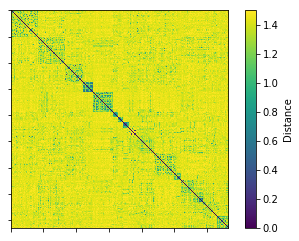

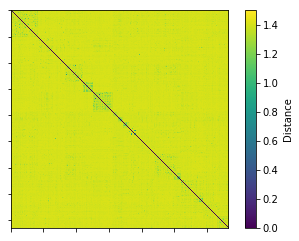

In [9]:
# Order the distance matrices according to clusters
clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx[i]

print((dist_red[:, clusters_idx_ordered][clusters_idx_ordered]/dist_red[:, clusters_idx_ordered][clusters_idx_ordered].max()).max())

fig = plt.figure()
plt.tick_params(
    axis='both',
    labelleft='off',
    labelbottom='off')
plt.imshow(dist_red[:, clusters_idx_ordered][clusters_idx_ordered],
           interpolation='nearest', vmin=0, vmax=maxdist)
plt.colorbar().set_label('Distance')
#plt.savefig('./../plots/text_mining/ordered_dist_matrix_reduced'+ ncomp+'c.png')
plt.show()

fig = plt.figure()
plt.tick_params(
    axis='both',
    labelleft='off',
    labelbottom='off')
plt.imshow(dist[:, clusters_idx_ordered][clusters_idx_ordered],
           interpolation='nearest', vmin=0, vmax=maxdist)
plt.colorbar().set_label('Distance')
#plt.savefig('./../plots/text_mining/ordered_dist_matrix.png')
plt.show()

As we can see in the Figures above, the smaller is the dimension of our vector space, the better is the performance of the clustering process. It is a fact we expected, since the more features we have to define our samples (drugs) the more difficult is for them to be similar.

#### STUFF TO DO..

- Evaluate the clusters (ATC distribution, histograms) Sometimes we have not one but several ATC codes...
- Write a conclusion (we got 8 out of 14 clusters..maybe there are not enough ATC codes from the missing ones so that we cannot discriminate them..)

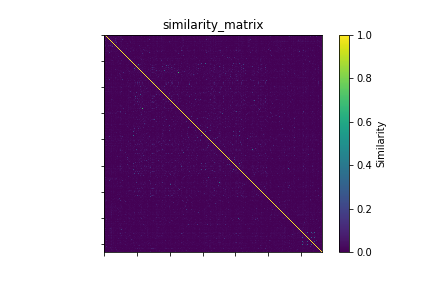

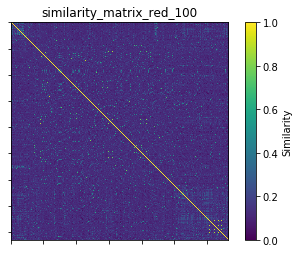

In [15]:
# Visual evaluation of Similarity
path_images = './../plots/text_mining/'

if not(os.path.exists('./../plots/text_mining/similarity_matrix.png')):
    save_similarity_matrix(numpy.array(sim_matrix), path_images, \
                       'similarity_matrix')
else: 
    img = Image(filename = path_images + "similarity_matrix.png", width=500, height=500)
    display(img)
    
if not(os.path.exists('./../plots/text_mining/similarity_matrix_red_'+ncomp+'.png')):
    save_similarity_matrix(numpy.array(sim_matrix_red), path_images, \
                       'similarity_matrix_red_'+ncomp)
else: 
    img = Image(filename = path_images + 'similarity_matrix_red_'+ncomp+'.png', width=500, height=500)
    display(img)

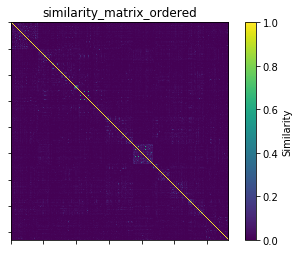

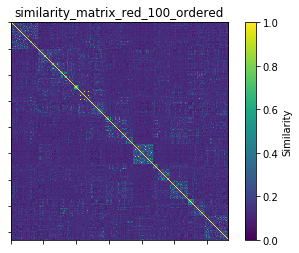

In [16]:
# Order the similarity matrices according to clusters
path_images = './../plots/text_mining/'

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx[i]
    
if not (os.path.exists('./../plots/text_mining/similarity_matrix_ordered.png')):
    save_similarity_matrix_ordered(numpy.array(sim_matrix), clusters_idx_ordered, path_images, \
                       'similarity_matrix_ordered')
else: 
    img = Image(filename = path_images + "similarity_matrix_ordered.png", width=500, height=500)
    display(img)
    
if not (os.path.exists('./../plots/text_mining/similarity_matrix_red_'+ncomp+'_ordered.png')):
    save_similarity_matrix_ordered(numpy.array(sim_matrix_red), clusters_idx_ordered, path_images, \
                       'similarity_matrix_red_'+ncomp+'_ordered')
else: 
    img = Image(filename = path_images + 'similarity_matrix_red_'+ncomp+'_ordered.png', width=500, height=500)
    display(img)

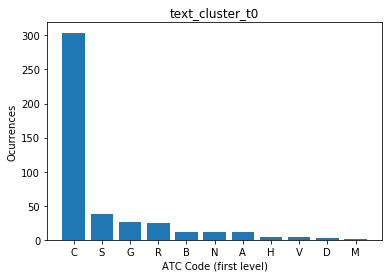

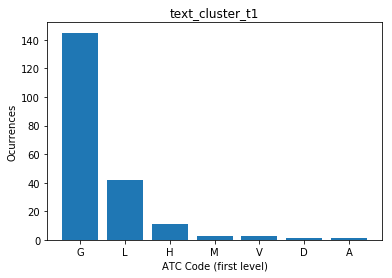

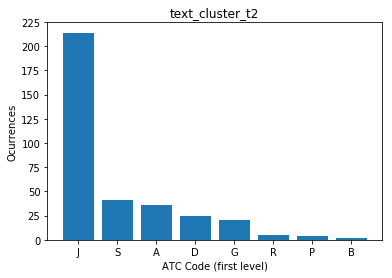

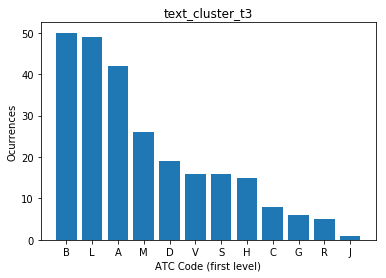

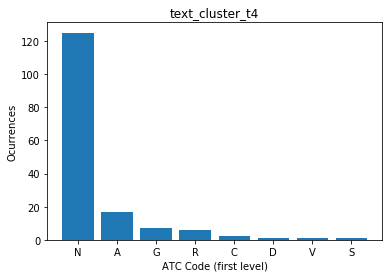

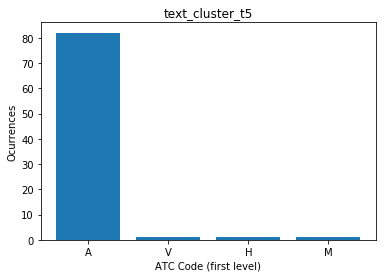

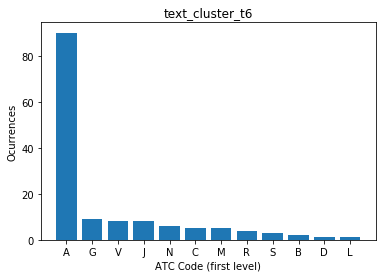

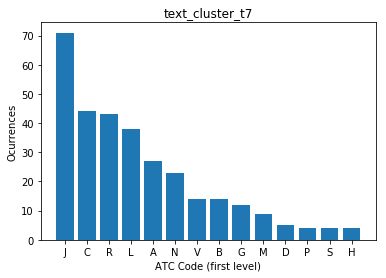

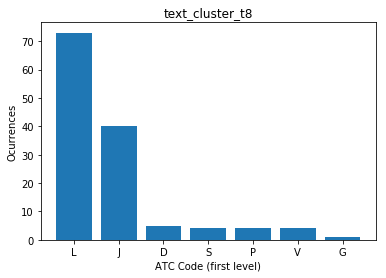

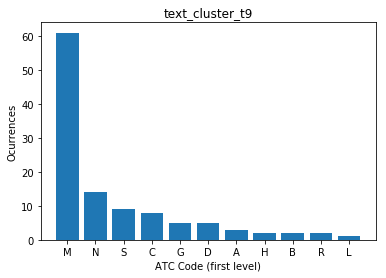

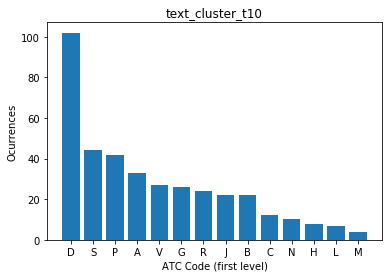

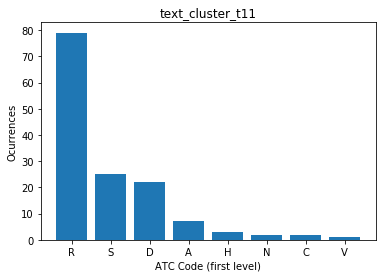

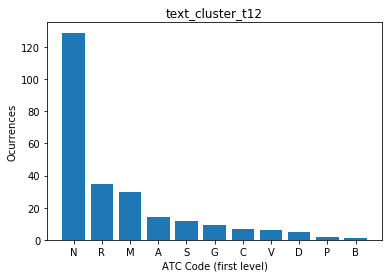

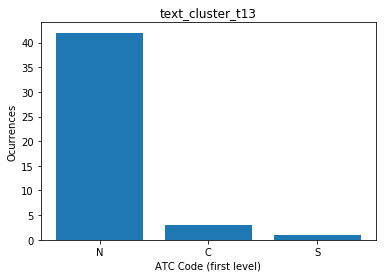

In [10]:
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = getattr(drugs[db_id], 'atc_codes')
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
path_images = './../plots/evaluation/clustering/text_mining/'

for i in range (0, len(clusters_ATC_distribution)):
    if not (os.path.exists('./../plots/evaluation/clustering/text_mining/text_cluster_'+str(i)+'.png')):
        save_histogram(clusters_ATC_distribution[i], path_images, \
                           'text_cluster_'+str(i))
    else: 
        img = Image(filename = path_images + 'text_cluster_'+str(i)+'.png', width=500, height=500)
        display(img)

In [11]:
ids = sorted(drugs.keys())
ids_dic = dict(enumerate(ids))

for ncomp in n_comp_list:
    print("\n\n------> Number of components for LSA: ", ncomp)
    dist_red = numpy.load('./../data/text_mining/dist_matrix_reduced'+str(ncomp)+'c.npy')
    norm_matrix_red = normalize_matrix(dist_red)
    sim_matrix_red = bidirectional_conversion_between_distance_and_similarity_matrix(norm_matrix_red)
    
    # Extract similarity for a list of pairs from a Similarity Matrix
    ground_truth_path = '../data/evaluation/ground_truth.csv'
    with open(ground_truth_path, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        ground_truth_list = list(reader)

    # We add an id for each pair (in order to evaluate afterwards the order infered by the similarity values)
    for i in range(0, len(ground_truth_list)):
        ground_truth_list[i].append(i)

    computed_similarity_list = compute_similarity_between_pairs(ids, sim_matrix_red, ground_truth_list)
    
    # Count number of pairs which actually are within our matrix
    n = len(computed_similarity_list)
    counter = 0
    for i in range(0, n):
        if computed_similarity_list[i][2] == -1:
            counter += 1
            
    print("The total of pairs from the ground truth is: ", n)
    print("The number of pairs we have from the total is: ", n - counter) # number of drugs which actually are in our matrix of similarity..
    
    # Here we evaluate two different things, if the order infered by the similarity values is the same in the pairs
    # and the correlation among the values of similarities predicted.
    
    # Necessary to not contemplate pairs which are not among our computed similarities (for the order correlation)
    computed_similarity_list_match = list()
    ground_truth_list_match = list()
    for i in range(0, len(computed_similarity_list)):
        if not computed_similarity_list[i][2] == -1:
            computed_similarity_list_match.append(computed_similarity_list[i])
            ground_truth_list_match.append(ground_truth_list[i])
    
    ground_truth_list_ordered = sorted(ground_truth_list, key=itemgetter(2)) # From 0 to 1 (similarity)
    computed_similarity_list_ordered = sorted(computed_similarity_list_match, key=itemgetter(2))

    print("Correlation between the order infered..")
    corr_order = ground_truth_evaluation_order(computed_similarity_list_ordered, ground_truth_list_ordered)
    print(corr_order)


    print("\nCorrelation between the values of the similarity..")
    corr_order = ground_truth_evaluation_value(computed_similarity_list, ground_truth_list)
    print(corr_order)

    print("\nAccuracy and recall using a threshold to determine similarity..")
    acc_threshold, recall_threshold = ground_truth_evaluation_threshold(computed_similarity_list, ground_truth_list, 0.85)
    print(acc_threshold, recall_threshold)



------> Number of components for LSA:  100
The total of pairs from the ground truth is:  97
The number of pairs we have from the total is:  65
Correlation between the order infered..
KendalltauResult(correlation=0.23269230769230764, pvalue=0.006141855951162044)

Correlation between the values of the similarity..
(0.7920365359241847, 3.9349013034459115e-15)

Accuracy and recall using a threshold to determine similarity..
0.7384615384615385 0.05555555555555555


------> Number of components for LSA:  200
The total of pairs from the ground truth is:  97
The number of pairs we have from the total is:  65
Correlation between the order infered..
KendalltauResult(correlation=-0.026923076923076918, pvalue=0.751215101577817)

Correlation between the values of the similarity..
(0.7505812923880141, 6.076001079445984e-13)

Accuracy and recall using a threshold to determine similarity..
0.7384615384615385 0.05555555555555555


------> Number of components for LSA:  500
The total of pairs from the